# Parallel Computing SpMV using CSR, ELL, and COO

In [1]:
# MLab UDMA library
import hyperfpga_cluster as hfc
import waveforms

import time
import tracemalloc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Assigned Nodes: ['hyperfpga-3be11-2-1', 'hyperfpga-3be11-3-0', 'hyperfpga-3be11-1-3']


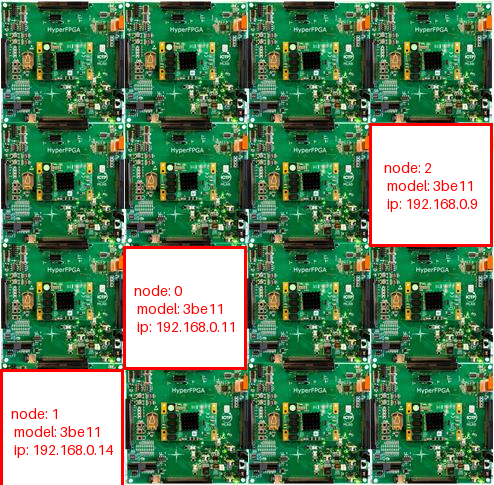

In [2]:
nodes = hfc.get_nodes()
nodes = hfc.get_nodes(view = True)

In [3]:
nodes = hfc.get_nodes()
test_nodes = nodes[0:3]
print(len(test_nodes))
cluster = hfc.HyperFPGACluster(nodes=test_nodes, firmware=['CSR512','ELL512','COO512'], n_engines=3)

cluster.create_profile()

await cluster.configure()

Assigned Nodes: ['hyperfpga-3be11-2-1', 'hyperfpga-3be11-3-0', 'hyperfpga-3be11-1-3']
3
Profile exists, rewritting configuration.
Uploading firmware...
b'/home/jupyter-kaust_ghala/Getting_Started/bitstreams/COO512-3be11.dtbo' -> b'' 000.01.07
 Programming fpgas...
Time taken to load BIN is 179.000000 Milli Seconds
BIN FILE loaded through FPGA manager successfully
Time taken to load BIN is 181.000000 Milli Seconds
BIN FILE loaded through FPGA manager successfully
Time taken to load BIN is 179.000000 Milli Seconds
BIN FILE loaded through FPGA manager successfully

 Node Status
 host: hyperfpga-3be11-2-1 state: operating
 firmware: CSR512 comblock: ['fifo_i', 'fifo_o', 'regs_i', 'regs_o']

 host: hyperfpga-3be11-3-0 state: operating
 firmware: ELL512 comblock: ['fifo_i', 'fifo_o', 'regs_i', 'regs_o']

 host: hyperfpga-3be11-1-3 state: operating
 firmware: COO512 comblock: ['fifo_i', 'fifo_o', 'regs_i', 'regs_o']



In [4]:
remote_client = cluster.start_and_connect_sync()
dview = remote_client[:]
node1 = remote_client[0]
node2 = remote_client[1]
node3 = remote_client[2]
dview.execute("""
import numpy as np
from comblock import Comblock
cb = Comblock()""")

Starting 3 engines with <class 'ipyparallel.cluster.launcher.SSHEngineSetLauncher'>
ensuring remote mlabadm@192.168.0.11:.ipython/profile_ssh/security/ exists
sending /home/jupyter-kaust_ghala/.ipython/profile_ssh/security/ipcontroller-1754895817-zuxl-client.json to mlabadm@192.168.0.11:.ipython/profile_ssh/security/ipcontroller-1754895817-zuxl-client.json
ensuring remote mlabadm@192.168.0.11:.ipython/profile_ssh/security/ exists
sending /home/jupyter-kaust_ghala/.ipython/profile_ssh/security/ipcontroller-1754895817-zuxl-engine.json to mlabadm@192.168.0.11:.ipython/profile_ssh/security/ipcontroller-1754895817-zuxl-engine.json
Running `python3 -m ipyparallel.engine --profile-dir=/home/mlabadm/.ipython/profile_ssh`
ensuring remote mlabadm@192.168.0.14:.ipython/profile_ssh/security/ exists
sending /home/jupyter-kaust_ghala/.ipython/profile_ssh/security/ipcontroller-1754895817-zuxl-client.json to mlabadm@192.168.0.14:.ipython/profile_ssh/security/ipcontroller-1754895817-zuxl-client.json
en

<AsyncResult(execute): pending>

### Generating a matrix and a vector

In [5]:
def generate_matrix(rows, cols):
    matrix = np.zeros((rows, cols), dtype=int)
    for i in range(rows):
        for j in range(cols):
            if (i + j) % 5 == 0:  # Sparse pattern
                matrix[i][j] = (i + j) % 10 + 1
    return matrix

def generate_vector(size):
    return [(i % 10) + 1 for i in range(size)]

matrix = generate_matrix(512, 512)
x = generate_vector(512)

### CSR Method

In [6]:
@node1.remote(block=True)
def funcIPcsr(matrix, x):
    values = []
    col_index = []
    row_ptr = [0]
    nnz = 0
    for row in matrix:
        for j, val in enumerate(row):
            if val != 0:
                values.append(val)
                col_index.append(j)
                nnz += 1
        row_ptr.append(nnz)
    data_in = row_ptr + col_index + values + x
    
    cb.fifo_out_clear()
    cb.fifo_in_clear()

    cb.write_reg(0, 1)
    for val in data_in:
        cb.write_fifo(int(val))
    
    result = cb.read_fifo(512)

    cb.write_reg(0, 0)
    
    return result



### ELL Method 

In [7]:
@node2.remote(block=True)
def funcIPell(matrix, x):
    padding_val=0
    invalid_index=4294967295
    max_nnz_per_row = max(np.count_nonzero(row) for row in matrix)
    num_rows = matrix.shape[0]
    ell_values = np.full((num_rows, max_nnz_per_row), padding_val)
    ell_col_index = np.full((num_rows, max_nnz_per_row), invalid_index)
    for i, row in enumerate(matrix):
        nz_idx = 0
        for j, val in enumerate(row):
            if val != 0:
                ell_values[i, nz_idx] = val
                ell_col_index[i, nz_idx] = j
                nz_idx += 1
    ell_vals = ell_values.tolist()
    ell_cols = ell_col_index.tolist()
    ell_vals_flat = [val for row in ell_vals for val in row]
    ell_col_flat = [idx for row in ell_cols for idx in row]
    data_in = ell_vals_flat + ell_col_flat + x
    
    cb.fifo_out_clear()
    cb.fifo_in_clear()

    cb.write_reg(0, 1) 
    
    for val in data_in:
        cb.write_fifo(int(val)) 

    result = cb.read_fifo(512)

    cb.write_reg(0, 0)
    
    return result 



### COO Method

In [8]:
@node3.remote(block=True)
def funcIPcoo(matrix, x):
    row_index = []
    col_index = []
    values = []
    for i, row in enumerate(matrix):
        for j, val in enumerate(row):
            if val != 0:
                row_index.append(i)
                col_index.append(j)
                values.append(val)
    data_in = row_index + col_index + values + x

    cb.fifo_out_clear()
    cb.fifo_in_clear()

    cb.write_reg(0, 1) 
    
    for val in data_in:
        cb.write_fifo(int(val)) 
        
    result = cb.read_fifo(512)

    cb.write_reg(0, 0)
    return result 



In [9]:
print(funcIPcsr(matrix, x))
print(funcIPell(matrix, x))
print(funcIPcoo(matrix, x))

[1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1

In [10]:
performance_data = []
def measure_performance(name, input_size):
    def decorator(func):
        def wrapper(*args, **kwargs):
            tracemalloc.start()
            start = time.perf_counter()
            result = func(*args, **kwargs)
            end = time.perf_counter()
            _, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            exec_time = end - start
            peak_kb = peak / 1024
            print(f"{name} | Input: {input_size} | Computation: {exec_time:.6f}s | Memory: {peak_kb:.2f} KB")
            performance_data.append({
                "Algorithm": name,
                "Input": input_size,
                "Computation Time (s)": exec_time,
                "Memory (KB)": peak_kb
            })
            return result
        return wrapper
    return decorator

In [11]:
@measure_performance("CSR", 512)
def run_csr():
    return funcIPcsr(matrix, x)

# Transmission time
tx_start = time.perf_counter()
result = run_coo()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time

@measure_performance("ELL", 512)
def run_ell():
    return funcIPell(matrix, x)

# Transmission time
tx_start = time.perf_counter()
result = run_coo()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time

@measure_performance("COO", 512)
def run_coo():
    return funcIPcoo(matrix, x)

# Transmission time
tx_start = time.perf_counter()
result = run_coo()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time

NameError: name 'run_coo' is not defined

In [ ]:
df = pd.DataFrame(performance_data)
print(df)

In [ ]:
await cluster.clean_cluster()

In [ ]:
df_CSR = df[df["Algorithm"] == "CSR"]
df_ELL = df[df["Algorithm"] == "ELL"]
df_COO = df[df["Algorithm"] == "COO"]

plt.figure(figsize=(15, 13))

plt.subplot(3, 3, 1)
for alg in df_CSR["Input"].unique():
    alg_df = df_CSR[df_CSR["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Computation Time (s)"], marker='o', label=alg)
plt.title("CSR Computation Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 2)
for alg in df_CSR["Input"].unique():
    alg_df = df_CSR[df_CSR["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Transmission Time (s)"], marker='o', label=alg)
plt.title("CSR Transmission Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 3)
for alg in df_CSR["Input"].unique():
    alg_df = df_CSR[df_CSR["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Memory (KB)"], marker='o', label=alg)
plt.title("CSR Memory Usage")
plt.xlabel("Input Size (n)")
plt.ylabel("Memory (KB)")
plt.legend()
plt.grid(True)

# -----------------------------------------


plt.subplot(3, 3, 4)
for alg in df_ELL["Input"].unique():
    alg_df = df_ELL[df_ELL["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Computation Time (s)"], marker='o', label=alg)
plt.title("CSR Computation Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 5)
for alg in df_ELL["Input"].unique():
    alg_df = df_ELL[df_ELL["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Transmission Time (s)"], marker='o', label=alg)
plt.title("CSR Transmission Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 6)
for alg in df_ELL["Input"].unique():
    alg_df = df_ELL[df_ELL["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Memory (KB)"], marker='o', label=alg)
plt.title("CSR Memory Usage")
plt.xlabel("Input Size (n)")
plt.ylabel("Memory (KB)")
plt.legend()
plt.grid(True)

# -----------------------------------------


plt.subplot(3, 3, 7)
for alg in df_COO["Input"].unique():
    alg_df = df_COO[df_COO["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Computation Time (s)"], marker='o', label=alg)
plt.title("CSR Computation Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 8)
for alg in df_COO["Input"].unique():
    alg_df = df_COO[df_COO["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Transmission Time (s)"], marker='o', label=alg)
plt.title("CSR Transmission Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 9)
for alg in df_COO["Input"].unique():
    alg_df = df_COO[df_COO["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Memory (KB)"], marker='o', label=alg)
plt.title("CSR Memory Usage")
plt.xlabel("Input Size (n)")
plt.ylabel("Memory (KB)")
plt.legend()
plt.grid(True)


plt.tight_layout()
#plt.savefig("spmv_performance_plot.png", dpi=300)
plt.show()
